##### TO DO NETWORK:
- normal costs
- proper nodes at one-way bridges, adding bridges to network

#### TO DO VESSELS:
- Attribute "Cost" on network vs distance function
- It starts logging after the first step, so start position is not included in the logs, only the position at t=1, not at t=0
- IDEA: let the path be found based on edge attribute. For example, create a special note attribute for cruisevessel, set dijkstra based on that attribute for specific round, and in the rest of the network set that specific note attribute to extremely high. Than dijkstra will choose the shortest route!



### Update
- Animation function; 'making a movie' -> way faster than putting it in HTML
- Time table distribution for RCV, 




In [1]:
#%load_ext autoreload
#%autoreload 2
import time
import random
# import geopandas as gpd
import networkx as nx
#import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
# from shapely.geometry import Point
from matplotlib import animation
from JSAnimation import IPython_display
#import copy
%matplotlib inline


import matplotlib.pylab as plt





In [2]:
#Show with attributes 
#graph = gpd.read_file('/Users/JeroenvanderDoes/Dropbox/Studie/Master/Thesis/Onderwerpen/Programs/QGIS/adjusted_complete_graph/edges_water_2.shp')
#print(graph.iloc[3]['cost'])
#print(graph.head()) # see what attrinutes the edges and nodes from the shapefile contain

## Generate Graph

In [3]:
G=nx.read_shp('../Canal_Network_Shapefiles/edges_water_3.shp', simplify=True) # use simplify is true otherwise chart get shifted
w_G = nx.Graph()

color_map = []
lat_lon_to_index = {}

for i, node in enumerate(G.nodes()): #adds nodes with label 1 till n nodes to the network. 
    w_G.add_node(i, pos= node)
    lat_lon_to_index[node] = i
    color_map.append('b')
    
for edge in G.edges(data=True): # adds edges with attributes to the graph from shapefile according to the order in which the edges are ordered in the shapefile
    w_G.add_edge(lat_lon_to_index[edge[0]], lat_lon_to_index[edge[1]], dis=edge[2]['cost'], width =edge[2]['width']  )

    
c = list(w_G.nodes)
j = list(w_G.edges(data=True))
#print(j)
#print(len(c))
#print(len(j))
    
#w_G = G.to_directed()

#nodelist omzetten naar pandas dataframe omdat zodat hij veel makkelijker en sneller de coordinaten van de nodes kan opzoeken
#pandas >>> nx.get_node_attributes kwa snelheid

graph_df = pd.DataFrame.from_dict(nx.get_node_attributes(w_G, 'pos'), orient='index', columns=["lat", "long"]) 

In [4]:
#plt.figure(figsize=(18,18))
#nx.draw(w_G, nx.get_node_attributes(w_G, 'pos'), with_labels=True, node_size=0.5, font_size = 0.1)
#plt.savefig('/Users/JeroenvanderDoes/Downloads/Amsterdam_Canals_newgraph.pdf', format='pdf', rasterized=False)
#plt.show()

## Path generator; Tour Vessels

In [5]:
cruise_vessel_routes_pd = pd.read_excel('./schema.xlsx', index_col = 'NAAM')
cruise_vessel_routes_pd = cruise_vessel_routes_pd.fillna("empty")

dict_waypoints={}
for i in cruise_vessel_routes_pd.index.tolist():
    dict_waypoints[i] = [int(x) for x in cruise_vessel_routes_pd.loc[:, 'NODES':].loc[i].tolist() if x != 'empty']
#print(dict_waypoints)


dict_routes = {}
for i in dict_waypoints:
    route = []
    total_route = []
    for x, j in enumerate(dict_waypoints[i][:len(dict_waypoints[i]) - 1]):
        l = nx.dijkstra_path(w_G,dict_waypoints[i][x] , dict_waypoints[i][x+1], weight = 'dis')
        route.append(l[:-1])
    route.append([route[0][0]])
    #print(route)
    for r in route:
        total_route += r
    dict_routes[i] = total_route
    
    


## Path generator; Random Tour Vessels

In [6]:
#max time for each round = 1;15 h
round_time = (75*60) / 10


dict_start_points={
    'prinsengracht' : 775,
    'rijksmuseum':1488,
    'annefrank': 1173,
    'damrak': 3167,
    'stationsplein': 3772
}

dict_attractions_2 ={
    'goudenbocht' : [1529, 1825, 2518, 2542, 2744, 3095, 3152, 3435],
    'annefrank' : [1173],
    'magerebrug': [3731],
    'redlightdistrict' : [2616, 2707, 3099, 3357, 3385],
    'prinsengracht' : [1055, 966, 830, 731],
    'artis' : [4841,4914, 4817, 4741, 4690],
    'rijksmuseum' : [1613, 1486],
    'stnicolaasbassilica' : [4422],
    'scheepsvaartmuseum' : [4652, 4630],
    'rembrandhuisenwaterlooplein' : [3367, 3285],
    'negenstraatjes' : [1334, 1297, 1255, 1181, 1136]  
}

dict_attractions ={
    'goudenbocht 1' : 1529, 
    'goudenbocht 2':1825,
    'annefrank' : 1173,
    'magerebrug': 3731,
    'redlightdistrict' : 2616,
    'prinsengracht' : 830,
    'artis' : 4741,
    'rijksmuseum' : 1613,
    'stnicolaasbassilica' : 4422,
    'scheepsvaartmuseum' : 4652,
    'rembrandhuisenwaterlooplein' : 3367,
    'negenstraatjes' : 1334   
}




## Onboard intelligence routeplanner random cruise vessels
### Lekker varen man!!

In [7]:
#on board intelligence

sightseeing_sample = random.sample(list(dict_attractions), 7)
sightseeing_sample_nodes = []
startpoint = random.sample(list(dict_start_points), 1)
startpoint_node = dict_start_points[startpoint[0]]

for i in sightseeing_sample:
    sightseeing_sample_nodes.append(dict_attractions[i])
print("start:", startpoint_node, startpoint)
print('sample:', sightseeing_sample)
print("sample nodes:", sightseeing_sample_nodes)


node_from_here = dict_start_points[startpoint[0]]

startpoint = dict_start_points[startpoint[0]]
total_path =[]

length_sample = len(sightseeing_sample_nodes)

def route_planner_captain(node_from_here, total_path, startpoint_begin):
    
    copy_w_G_totaal= w_G.copy() # keeps track on path actually visited as input for next iteration
    total_round = 6500
    
    for i in range(len(sightseeing_sample_nodes)):
        #maak kopie van graaf
        #plot pad
        #pas kopie van graaf aan 
        #calculate route terug 
        #discard hem & maak nieuwe kopie van graaf 
        
        minimal_distance_next_attraction = 100000000000000
        
        #calculates distance + distance back for each attraction
        for attraction in sightseeing_sample_nodes:
          
            copy_w_G_1 = copy_w_G_totaal.copy()# maak een kopie
            
            distance_attraction = nx.dijkstra_path_length(copy_w_G_1, node_from_here, attraction, weight = 'dis')
            
            print("attraction selected: ", attraction)
            #print("distance to attraction:", distance_attraction)
            
            
            path_attraction = nx.dijkstra_path(copy_w_G_1, node_from_here, attraction, weight = 'dis')
            
            #if path taken, add a distance penalty so that the path back will not have edges from route to attraction
            for i in range(len(path_attraction)-1):
                #copy_w_G_1.edges[ path_attraction[i], path_attraction[i+1] ] ['visted'] = True
                copy_w_G_1.edges[ path_attraction[i], path_attraction[i+1] ] ['dis'] *= 2
                      
       
            distance_attraction_back_home = nx.dijkstra_path_length(copy_w_G_1, attraction, node_from_here, weight = 'dis')
            #print("distance back home:", distance_attraction_back_home)
            
            path_attraction_back = nx.dijkstra_path(copy_w_G_1, attraction, startpoint_begin, weight = 'dis')
            #print("total round:", (total_round)) 
            print("total distance to attraction & backhome:" , distance_attraction + distance_attraction_back_home )
            #print("MINIMAL DISTANCE NEXT ATTRACTION", minimal_distance_next_attraction)
            
            #select attraction with shortest distance 
            if distance_attraction < minimal_distance_next_attraction:
                
                
                minimal_distance_next_attraction = distance_attraction
              
                path_next_attraction = path_attraction
                
                distance_back_from_next_node = distance_attraction_back_home
                path_back_from_next_node = path_attraction_back
                
                next_attraction = attraction
                print("MINIMAL DISTANCE NEXT ATTRACTION UPDATED:", minimal_distance_next_attraction)
                print("distance back home:", distance_back_from_next_node)
                
            del copy_w_G_1
            
        #if path to that attraction & back can be fitted into that round; sail en loop again. if not; sail back to start
        if minimal_distance_next_attraction + distance_back_from_next_node < total_round:
            total_round -= minimal_distance_next_attraction

            sightseeing_sample_nodes.remove(next_attraction)
            node_from_here  = next_attraction
            final_path_back  = path_back_from_next_node
            final_distance_back = distance_back_from_next_node
            
            #when sailing to attraction, add penalty on edges where the boat has sailed on. This is input for next iteration.
            # keeps track on path actually visited as input for next iteration
            for i in range(len(path_next_attraction)-1):
                copy_w_G_totaal.edges[ path_next_attraction[i], path_next_attraction[i+1] ] ['dis'] *=2  
                #copy_w_G_1.edges[ path_attraction[i], path_attraction[i+1] ] ['visted'] = True
    
            #add path to total path
            for i in path_next_attraction:
                total_path.append(i)
                #staan nog dubbele tussen
                
        #if no attraction is near, return this error
        elif len(sightseeing_sample_nodes)==length_sample:
            print("No Attraction can be found")
            break
            
        else:
            ##if path to that attraction & back can be fitted into that round; sail en loop again. if not; sail back to start. 
            #path_back_home = nx.dijkstra_path(copy_w_G_totaal, node_from_here, startpoint, weight = 'dis')
            #distance_back_home = nx.dijkstra_path_length(copy_w_G_totaal, node_from_here, startpoint, weight = 'dis')
            total_round -= final_distance_back
            print("total round with retour :", 6000- total_round)
            for i in final_path_back:
                total_path.append(i)
                # hij pakt het pad terug van de next node, ipv van de vorige node
                
            break
            

        print("NEXT ATTRARACTION: ", next_attraction)
        #print("distance next attraction: ", distance_next_attraction)
        print("SAMPLE", sightseeing_sample_nodes)
        print("TOTAL ROUND PASSED:", (6000 - total_round))
        print("NEXT ITERATION")
        
            

route_planner_captain(node_from_here, total_path, startpoint)




start: 1173 ['annefrank']
sample: ['artis', 'goudenbocht 1', 'goudenbocht 2', 'scheepsvaartmuseum', 'redlightdistrict', 'negenstraatjes', 'prinsengracht']
sample nodes: [4741, 1529, 1825, 4652, 2616, 1334, 830]
attraction selected:  4741
total distance to attraction & backhome: 7635.142462729424
MINIMAL DISTANCE NEXT ATTRACTION UPDATED: 3509.5322649498407
distance back home: 4125.610197779583
attraction selected:  1529
total distance to attraction & backhome: 2678.754656747745
MINIMAL DISTANCE NEXT ATTRACTION UPDATED: 1170.2083077663924
distance back home: 1508.5463489813526
attraction selected:  1825
total distance to attraction & backhome: 3074.5294859176624
attraction selected:  4652
total distance to attraction & backhome: 6496.607121883179
attraction selected:  2616
total distance to attraction & backhome: 4935.533006046004
attraction selected:  1334
total distance to attraction & backhome: 847.8486682377256
MINIMAL DISTANCE NEXT ATTRACTION UPDATED: 289.9256416076024
distance back

## Vessel Base Class

In [8]:
class Vessel(object):
    def __init__(self, start, end):
        """
        Baseclass Vessel kan worden overschreven door nieuwe __init__ aan te maken. 
        Dan moet je wel alle waardes opnieuw bepalen, dus zorg dat je goed copy pasted en alleen de waardes veranderd die
        je wilt veranderen. In dit geval dat het start en eind punt dus bepaald zijn, en dus niet meer als input moet worden gegeven
        omdat het pad al bepaald is. 
        """
        self.start = start#; Moeten in child classes wel worden gedefinieerd, anders doen deze schepen het niet.
        self.end = end
        self.path = self.route(w_G,self.start, self.end)
        self.coor_log = []
        self.vessel_pos = (graph_df['lat'].loc[self.path[0]], graph_df['long'].loc[self.path[0]]) # nx.get_node_attributes(w_G, 'pos')[self.path[0]] 
        self.w_G = w_G
        self.to_node_id = 1
        self.move = 3 #aanpassen vooor de tijdsstap, nu  in m/s, en pas aan voor overshoot. 
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]
        #self.start_time = simulation.step_count
        

    def route(self, w_G, start, end):
        return nx.dijkstra_path(w_G, start, end, weight = 'dis')
    
    
    def calculate_distance(self, Node1, Node2):
        # calculate distance between two points
        distance = float(((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5)
        return float(distance)
    

    def calculate_angle(self, Node1, Node2):
        # calculate angle going from point 1 to point 2 (NB: atan2(y,x))
        angle =  (float(math.atan2(Node2[1]-Node1[1],Node2[0]-Node1[0]))) #*float((180.0 / math.pi)) for degrees
        return float(angle)
        

    def pos_next_step(self, Node1, Node2, move):#move cannot be replaced by self.move because move may change by 'remaining_move'
        # move towards Node2
        distance = self.calculate_distance(Node1, Node2) #wordt dit wel hier gebruikt?
        angle = self.calculate_angle(Node1, Node2)
        new_node = (float(Node1[0]+math.cos(angle)*move), float(Node1[1]+math.sin(angle)*move))
        return new_node

    
    def move_on_path(self):
        # 1. vessel_pos is your boat
        # 2. you need to know the next node in the path
        # 3. calculate the distance between Node1 and the next node
        
        if self.active == True: #start logging  each step of vessel;
            
            to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
            distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)

            # If move <= distance to next node, make move
            if self.move < distance_to_next_node:
                    vessel_pos_new = self.pos_next_step(self.vessel_pos, to_node_pos, self.move)
                    self.travel_time+=1

            else:
                if self.to_node_id == len(self.path)-1:
                    self.active = False #stop logging if vessel arrives at destination
                    vessel_pos_new = to_node_pos  
                    self.travel_time +=1 # klopt dit dan nog?
                else:
                    # reposition vessel at next node and calculate remaining move distance
                    self.vessel_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])

                    # up the to_node_id with 1 and find new to_node_pos
                    self.to_node_id+=1
                    
                    # calculate distance to next node
                    remaining_move = float(self.move-distance_to_next_node)
                    
                    #updates new distance to next node
                    to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                    distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)
                    
                    #checks for 'overshoot', if remaining distance > next distance, place on next node and check again till condition is no longer valid
                    while remaining_move > distance_to_next_node:
                        self.vessel_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                        remaining_move = float(remaining_move-distance_to_next_node)
                        
                        # if statement to check if it is on end of path (last point of path could be couple of nodes which lengt < move)
                        #otherwise, node_id > len of path and can;t compute
                        if self.to_node_id == len(self.path)-1:
                            self.active = False #stop logging if vessel arrives at destination
                            vessel_pos_new = to_node_pos  
                            self.travel_time +=1
                            break
                            
                        self.to_node_id+=1
                        
                        #vessel is placed on new node, now update distance to next node 
                        to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                        distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)
                        
                    vessel_pos_new = self.pos_next_step(self.vessel_pos, to_node_pos, remaining_move)
                    self.travel_time+= 1   
                    
            #updates position of vessel
            self.vessel_pos = vessel_pos_new
            
            #adds new positions to log
            self.coor_log.append(self.vessel_pos) #library for tuple (x,y) coordinate of the vessel
            self.coor_log_x.append(self.vessel_pos[0]) # library for only x coordinates
            self.coor_log_y.append(self.vessel_pos[1])# library for only y coordinates
            


## Vessel sub-categories

In [9]:
class Cruise_Vessel(Vessel):

     #TODO: is het niet beter baseclass aan te passen zodat er geen start, end is gedefinieerd?
    def __init__(self):
        #self.start = doesn't have one hardcoded, reads one from excel file
        #self.end = doesn't have one hardcoded, reads one from excel file
        self.path = dict_routes['css1'] #path bij init, zodat simulator classe dat zelf kan bepalen
        self.coor_log = []
        self.vessel_pos = (graph_df['lat'].loc[self.path[0]], graph_df['long'].loc[self.path[0]]) #start position
        self.to_node_id = 1
        self.move = 16.67 #aanpassen vooor de tijdsstap, nu  in m/s, en pas aan voor overshoot. 
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]

    #def starttime? Of moet die in de simulator class worden gedaan? -> Simulator classe
        

In [10]:
class Random_Cruise_Vessel(Vessel):
    def __init__(self):
        
        self.path = total_path
        self.vessel_pos = (graph_df['lat'].loc[self.path[0]], graph_df['long'].loc[self.path[0]]) #start position
        self.to_node_id = 1
        self.move = 13.89 #aanpassen vooor de tijdsstap, nu  in m/s, en pas aan voor overshoot. 
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]
        self.coor_log = []
    

     #TODO: is het niet beter baseclass aan te passen zodat er geen start, end is gedefinieerd?
      
    def route(self, w_G, start, end):
        pass
        
     
        
        
        
        
    #insert logica for touristiness certain edges
    
    
    
    

In [11]:
class Pleasure_Craft(Vessel):
    
    #TODO: is het niet beter baseclass aan te passen zodat er geen start, end is gedefinieerd?
    def __init__(self):
        self.path = self.route(w_G,random.sample(w_G.nodes, 1)[0], random.sample(w_G.nodes, 1)[0])
        self.start = self.path[0]
        self.end = self.path[len(self.path)-1]
        self.coor_log = []
        self.vessel_pos = nx.get_node_attributes(w_G, 'pos')[self.path[0]] 
        self.w_G = w_G
        self.to_node_id = 1
        self.move = 3.0 #aanpassen vooor de tijdsstap, nu  in m/s, en pas aan voor overshoot. 
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]

        #def route(self, w_G, start, end):
        #return random.sample(nx.all_simple_paths(w_G, start, end, cutoff=None))
        #nx.all_simple_paths(w_G, start, end, cutoff=None)[0]
     
        
        

## SIMULATOR CLASS

In [12]:
class Simulation():
    def __init__(self):
        self.stepsize = 10
        self.sim_steps = 1000 #int((24*60*60)/self.stepsize)
        self.vessel_count = 10
        self.ves_list = [] #list of active vessel
        self.start_time_list = [] # list for starttimes for vessel for pd.dataframe
        #self.druktelijst_rtv = [0,0,0,0,0,15,16,17,27,28,38,47,46,45,44,47,37,28,25,34,12,11,5,3] #from excel?
        self.druktelijst_rtv = [0,0,0,0,0,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # for fast simulations
        self.druktelijst_pc = [0,0,0,0,0,15,16,17,27,28,38,47,46,45,44,47,37,28,25,34,12,11,5,3] #from excel?
        self.distr = self.distr_gen() #chance generator for distribution of vessel of a given day, can be modified to represent different scenarios
        self.distr_rtv = self.distr_gen_from_distr_list(self.druktelijst_rtv)
        self.distr_pc = self.distr_gen_from_distr_list(self.druktelijst_pc)
        self.step_count = 0
        
        
    def run_full_sim(self):
        for i in range(self.sim_steps):
            self.one_sim_step()
            print(i)
        #print("simlation time: {} s".format(time.time() - self.start_time)) 
        #Create pandas dataframe of vessels log' for plotting purposes.
#         self.df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))# generate dataframe based on rows: # steps ; colums: # vessels
        self.x_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        self.y_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        
        
        #self.from_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        
        for i, time, ves in zip(range(len(self.ves_list)), self.start_time_list, self.ves_list):
            
            #creates dataframe for x coordinates and one for y coordinates based on vessel logs
            ds_x = pd.Series(np.array(ves.coor_log_x, dtype = np.float64))
            ds_y = pd.Series(np.array(ves.coor_log_y, dtype = np.float64))
        
            
            """only adds coordinates stamps as column in data frame based on timestep in start_time_list; so if a vessel is generated in timestep 20 and
            logs every step and arrives at timestep 30, the coordinates of the timesteps 20 untill 30 are added to the dataframe
            on row 20 untill 30. """
            
            self.x_df[i].iloc[time : time + len(ds_x)] = ds_x.values
            self.y_df[i].iloc[time : time + len(ds_y)] = ds_y.values
            #self.x_df.at[i, time : time + len(ds_x) ] = ds_x.values
            #self.y_df.at[i, time : time + len(ds_x) ] = ds_y.values
            
            #self.x_df[i].at[time : time + len(ds_x)] = ds_x.values
            #self.y_df[i].at[time : time + len(ds_y)] = ds_y.values
            
            
            
            #replaces values of 0 to nan for plotting purposes
            self.x_df = self.x_df.replace(0.0, np.nan) 
            self.y_df = self.y_df.replace(0.0, np.nan)
        
    def one_sim_step(self):
         #definieerd verschillende schepen met schillende routes en starttijden.
        
        #for x in range(self.distr[self.step_count]):# generates list of number of boats to be generated for a timestep
            
         #   self.ves_list.append(Cruise_Vessel())
          #  self.start_time_list.append(self.step_count) # Generate list of starttimes whenever a vessel is generated for pd.DataFrame
            
        for y in range(self.distr_rtv[self.step_count]):
            
            self.ves_list.append(Random_Cruise_Vessel())
            self.start_time_list.append(self.step_count)
        
        #for z in range(self.distr_pc[self.step_count]):
            
         #   self.ves_list.append(Pleasure_Craft())
          #  self.start_time_list.append(self.step_count)
            
        
        for ves in self.ves_list:
            ves.move_on_path()
        
        self.step_count += 1

        
   
    def distr_gen(self): # voeg boot toe met bepaalde kans 
        threshold = self.vessel_count / float(self.sim_steps)
        count_list = []
    
        # maakt lijst met hoeveel boten er spawnen op elke tijdstap
        for i in range(self.sim_steps):
            counter = 0
            
            while True:
                nummer = random.random()
                if nummer < threshold:
                    counter += 1
                else:
                    break
            count_list.append(counter)
        #print (count_list)
        return count_list
    
    
    def distr_gen_from_distr_list(self, druktelijst):
        start_time = time.time()
        
        te_returnen_lijst = []
        for uurdrukte in druktelijst:

            uurlijst = list(np.zeros(round(self.sim_steps/len(druktelijst)), dtype = int))
            for i in range(uurdrukte):
                uurlijst[random.choice(range(len(uurlijst)))] += 1
            te_returnen_lijst += uurlijst
     
        if self.sim_steps > len(te_returnen_lijst):
            for i in range(self.sim_steps - len(te_returnen_lijst)):
                te_returnen_lijst.append(0)
                
        elif len(te_returnen_lijst) > self.sim_steps:
            te_returnen_lijst = te_returnen_lijst[:len(te_returnen_lijst) - (len(te_returnen_lijst) - self.sim_steps)]
            
        return te_returnen_lijst


  

## Start Simulation(s)

In [13]:
start_time = time.time()
simulation = Simulation()
simulation.run_full_sim()
print("Simulation : {} s".format(time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Checks log of vessel if needed

In [14]:
#simulation.x_df #Log of route 

## Animator + Plot of routes


<IPython.core.display.Javascript object>


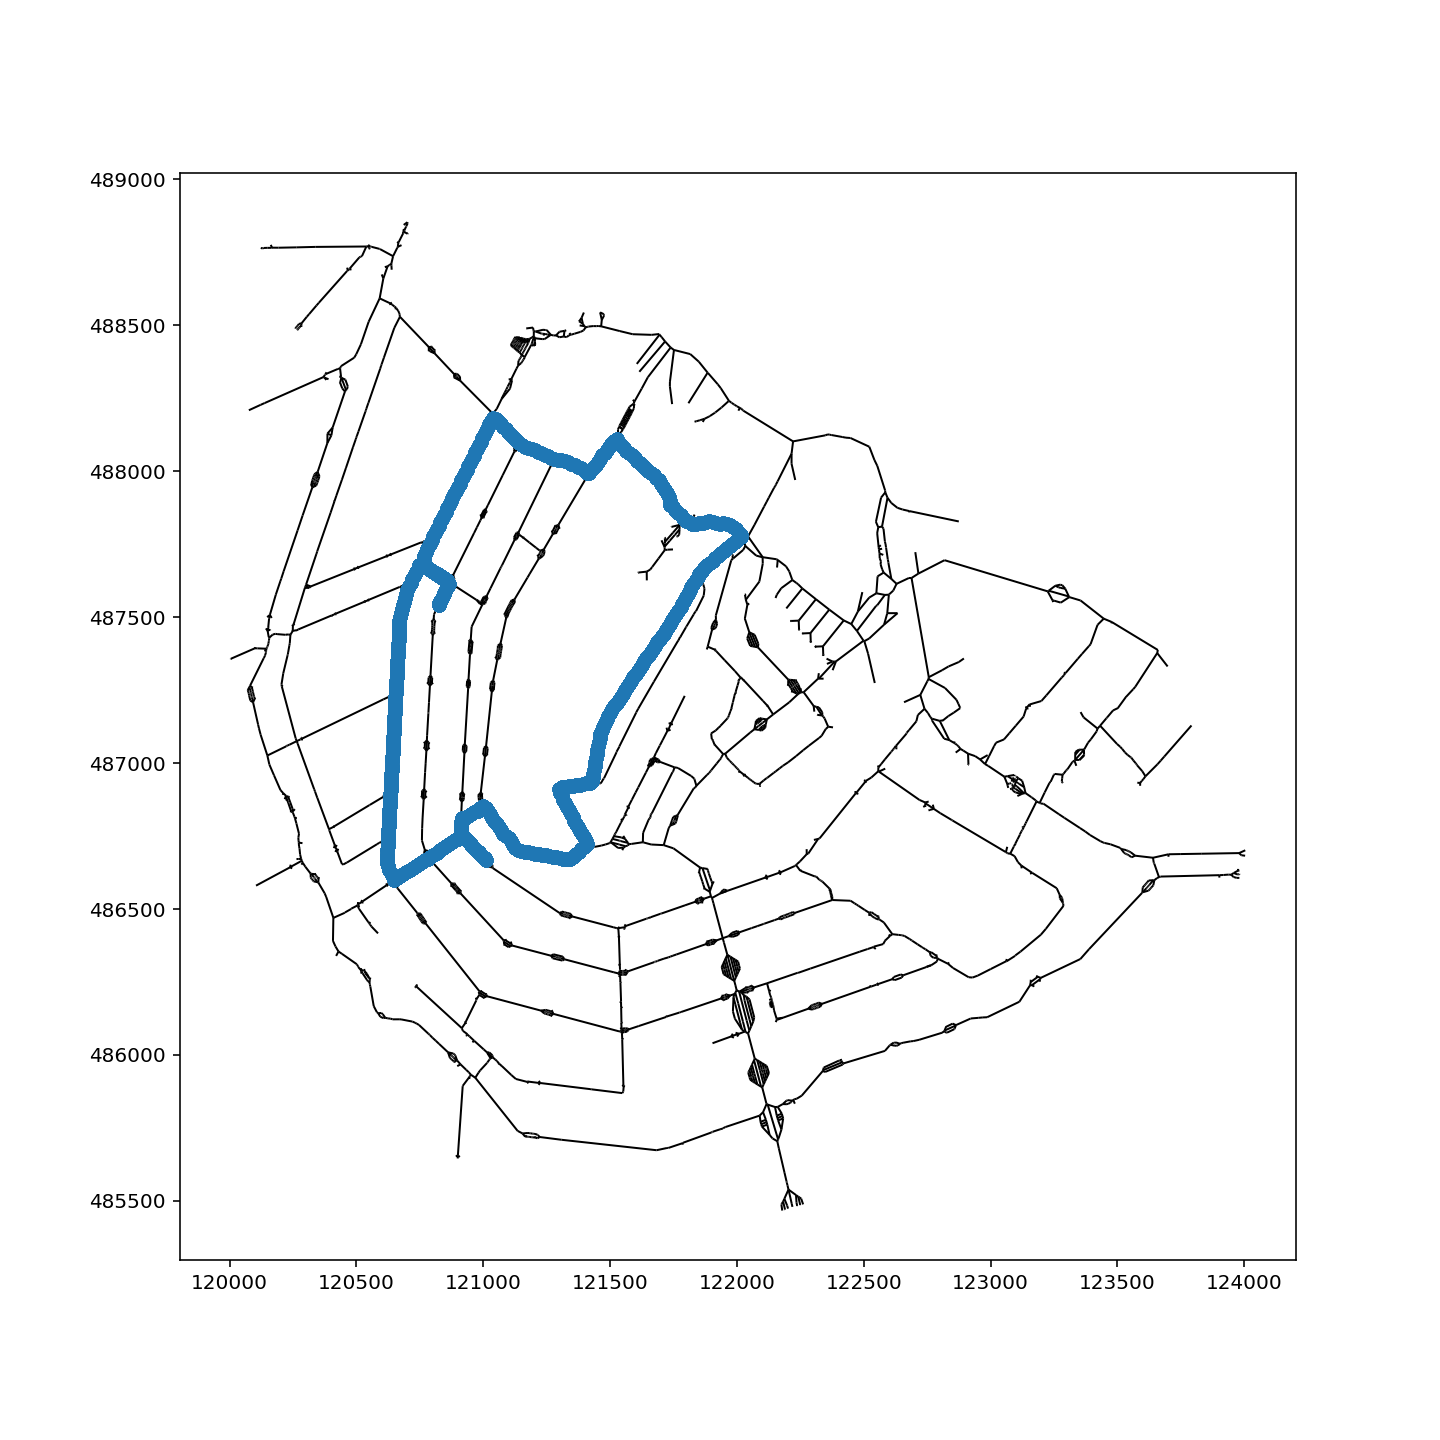

/Users/JeroenvanderDoes/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
nx.draw_networkx_edges(w_G,nx.get_node_attributes(w_G, 'pos'))
plt.scatter(simulation.x_df,simulation.y_df)
#plt.savefig('/Users/JeroenvanderDoes/Downloads/Amsterdam_Canals_11.pdf', format='pdf', rasterized=False)
plt.show()


In [16]:

"""
start_time = time.time()

def get_data_x(i):
    return simulation.x_df.loc[i]

def get_data_y(i):
    return simulation.y_df.loc[i]

def animate(i):
    x = get_data_x(i)
    y= get_data_y(i)   
    graph.set_data(x,y)
    return graph,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()

nx.draw(w_G,nx.get_node_attributes(w_G, 'pos'),node_size = 0.1)

n_steps = simulation.x_df.index 

graph, = plt.plot([],[],'o')

ani = animation.FuncAnimation(fig, animate, frames= n_steps, interval=1, repeat=True, blit = True)
ani.save('/Users/JeroenvanderDoes/Downloads/canals_test2.mp4', writer=writer)

print("Animator : {} s".format(time.time() - start_time))
"""

'\nstart_time = time.time()\n\ndef get_data_x(i):\n    return simulation.x_df.loc[i]\n\ndef get_data_y(i):\n    return simulation.y_df.loc[i]\n\ndef animate(i):\n    x = get_data_x(i)\n    y= get_data_y(i)   \n    graph.set_data(x,y)\n    return graph,\n\n# Set up formatting for the movie files\nWriter = animation.writers[\'ffmpeg\']\nwriter = Writer(fps=15, metadata=dict(artist=\'Me\'), bitrate=1800)\n\nfig = plt.figure(figsize=(20,20))\nax = plt.axes()\n\nnx.draw(w_G,nx.get_node_attributes(w_G, \'pos\'),node_size = 0.1)\n\nn_steps = simulation.x_df.index \n\ngraph, = plt.plot([],[],\'o\')\n\nani = animation.FuncAnimation(fig, animate, frames= n_steps, interval=1, repeat=True, blit = True)\nani.save(\'/Users/JeroenvanderDoes/Downloads/canals_test2.mp4\', writer=writer)\n\nprint("Animator : {} s".format(time.time() - start_time))\n'